In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler


In [2]:
#Read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893proj/crash_weather.csv", inferSchema=True, header=True)

df.show(1)

+-------------+--------+--------+---------+---------+--------------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------+--------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+-------------------+-----------------+--------------+-----------------+
|    simp_date| borough|zip code| latitude|longitude|            location|     off street name|number of persons injured|number of persons killed|number of pedestrians injured|number of pedestrians killed|number of cyclist injured|number of cyclist killed|number of motorist injured|number of motorist killed|collision_id|                date|            time|temperature_2m (°C)|precipitation (mm)|rain

In [3]:
df1 = df.select("simp_date", "latitude", "longitude", "borough")
df1.show(3)

+-------------+---------+---------+--------+
|    simp_date| latitude|longitude| borough|
+-------------+---------+---------+--------+
|2021-09-11 09|40.667202| -73.8665|BROOKLYN|
|2021-12-14 08| 40.86816|-73.83148|   BRONX|
|2021-12-14 21| 40.67172| -73.8971|BROOKLYN|
+-------------+---------+---------+--------+
only showing top 3 rows



In [4]:
df1 = df1.withColumn('month', split(df['simp_date'], '-').getItem(1))
df1 = df1.drop('simp_date')
df1.show(truncate=False)
df1.printSchema()

+------------------+----------+-------------+-----+
|latitude          |longitude |borough      |month|
+------------------+----------+-------------+-----+
|40.667202         |-73.8665  |BROOKLYN     |09   |
|40.86816          |-73.83148 |BRONX        |12   |
|40.67172          |-73.8971  |BROOKLYN     |12   |
|40.75144          |-73.97397 |MANHATTAN    |12   |
|40.675883999999996|-73.75577 |QUEENS       |12   |
|40.66684          |-73.78941 |QUEENS       |12   |
|40.68158          |-73.97463 |BROOKLYN     |12   |
|40.65068          |-73.95881 |BROOKLYN     |12   |
|40.87262          |-73.904686|BRONX        |12   |
|40.748917         |-73.993546|MANHATTAN    |12   |
|40.75373          |-73.88505 |QUEENS       |12   |
|40.63165          |-74.08762 |STATEN ISLAND|12   |
|40.623104         |-73.95809 |BROOKLYN     |12   |
|40.66576          |-73.9845  |BROOKLYN     |12   |
|40.687534         |-73.9775  |BROOKLYN     |12   |
|40.710957         |-73.951126|BROOKLYN     |12   |
|40.81813   

### QUEENS_spring

In [5]:
spring = df1.rdd.filter(lambda x: x[3]=='03' or x[3]=='04' or x[3]=='05')
spring = spring.filter(lambda x: x[2]=="QUEENS")
spring = spring.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
spring = spring.map(lambda x: [x[0], x[1]])

loc_spring = spring.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_spring)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
| 40.69261| -73.81143|[40.69261,-73.81143]|
|40.745235|-73.937706|[40.745235,-73.93...|
|40.758705| -73.93793|[40.758705,-73.93...|
|40.695156|-73.845406|[40.695156,-73.84...|
|40.734375| -73.87342|[40.734375,-73.87...|
|40.699947|-73.736626|[40.699947,-73.73...|
| 40.69614| -73.81789|[40.69614,-73.81789]|
|40.675167|-73.825264|[40.675167,-73.82...|
|40.742508| -73.91788|[40.742508,-73.91...|
| 40.67478|-73.806206|[40.67478,-73.806...|
|40.702972|-73.888054|[40.702972,-73.88...|
| 40.76532|-73.771904|[40.76532,-73.771...|
|40.776764|-73.848015|[40.776764,-73.84...|
|40.747498| -73.91309|[40.747498,-73.91...|
| 40.69349|-73.826546|[40.69349,-73.826...|
|40.726463| -73.85943|[40.726463,-73.85...|
|40.678417|-73.729225|[40.678417,-73.72...|
|40.692596| -73.79078|[40.692596,-73.79...|
|40.676304|-73.816284|[40.676304,-73.81...|
|40.743534| -73.93951|[40.743534

In [6]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
| 40.69261| -73.81143|[40.69261,-73.81143]|        10|
|40.745235|-73.937706|[40.745235,-73.93...|         1|
|40.758705| -73.93793|[40.758705,-73.93...|         7|
|40.695156|-73.845406|[40.695156,-73.84...|        12|
|40.734375| -73.87342|[40.734375,-73.87...|         5|
|40.699947|-73.736626|[40.699947,-73.73...|        13|
| 40.69614| -73.81789|[40.69614,-73.81789]|        10|
|40.675167|-73.825264|[40.675167,-73.82...|        10|
|40.742508| -73.91788|[40.742508,-73.91...|        18|
| 40.67478|-73.806206|[40.67478,-73.806...|        10|
|40.702972|-73.888054|[40.702972,-73.88...|         4|
| 40.76532|-73.771904|[40.76532,-73.771...|         0|
|40.776764|-73.848015|[40.776764,-73.84...|        19|
|40.747498| -73.91309|[40.747498,-73.91...|        18|
| 40.69349|-73.826546|[40.69349,-73.826...|        10|
|40.726463

In [7]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.75719965 -73.77658471]
[ 40.74285777 -73.94208566]
[ 40.67881348 -73.84731799]
[ 40.74580273 -73.72256835]
[ 40.70755672 -73.8991724 ]
[ 40.74011697 -73.86434732]
[ 40.60067744 -73.75941249]
[ 40.7609167  -73.92805801]
[ 40.66951012 -73.74218011]
[ 40.58768224 -73.82226463]
[ 40.68228369 -73.81557045]
[ 40.77034562 -73.91005619]
[ 40.71094624 -73.84456512]
[ 40.71080562 -73.75018637]
[ 40.71150029 -73.79931756]
[ 40.67487194 -73.77485495]
[ 40.75501592 -73.88242816]
[ 40.75476247 -73.8220795 ]
[ 40.74024911 -73.90585354]
[ 40.78100416 -73.82905357]


Text(0.5,1,'QUEENS_spring')

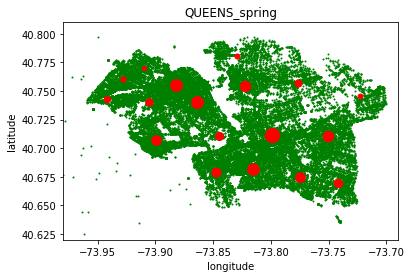

In [8]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/300)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_spring")

### QUEENS_summer

In [9]:
summer = df1.rdd.filter(lambda x: x[3]=='06' or x[3]=='07' or x[3]=='08')
summer = summer.filter(lambda x: x[2]=="QUEENS")
summer = summer.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
summer = summer.map(lambda x: [x[0], x[1]])

loc_summer = summer.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_summer)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.609535| -73.75372|[40.609535,-73.75...|
|40.600792| -73.76711|[40.600792,-73.76...|
|40.589592|-73.786385|[40.589592,-73.78...|
| 40.59723| -73.76237|[40.59723,-73.76237]|
| 40.68651| -73.76815|[40.68651,-73.76815]|
|40.688435| -73.78765|[40.688435,-73.78...|
| 40.59312|-73.772705|[40.59312,-73.772...|
|40.609535| -73.75372|[40.609535,-73.75...|
|40.763496| -73.87814|[40.763496,-73.87...|
|40.686646|-73.849075|[40.686646,-73.84...|
| 40.60675|-73.756645|[40.60675,-73.756...|
|40.777496| -73.90784|[40.777496,-73.90...|
|  40.6974| -73.80952| [40.6974,-73.80952]|
| 40.67897| -73.75985|[40.67897,-73.75985]|
|40.694294| -73.74868|[40.694294,-73.74...|
|40.597824|-73.782524|[40.597824,-73.78...|
| 40.60303| -73.75316|[40.60303,-73.75316]|
| 40.59702|-73.749084|[40.59702,-73.749...|
|40.609913| -73.75364|[40.609913,-73.75...|
|40.592678| -73.78349|[40.592678

In [10]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.609535| -73.75372|[40.609535,-73.75...|        16|
|40.600792| -73.76711|[40.600792,-73.76...|        16|
|40.589592|-73.786385|[40.589592,-73.78...|        16|
| 40.59723| -73.76237|[40.59723,-73.76237]|        16|
| 40.68651| -73.76815|[40.68651,-73.76815]|        18|
|40.688435| -73.78765|[40.688435,-73.78...|         0|
| 40.59312|-73.772705|[40.59312,-73.772...|        16|
|40.609535| -73.75372|[40.609535,-73.75...|        16|
|40.763496| -73.87814|[40.763496,-73.87...|         9|
|40.686646|-73.849075|[40.686646,-73.84...|         6|
| 40.60675|-73.756645|[40.60675,-73.756...|        16|
|40.777496| -73.90784|[40.777496,-73.90...|         1|
|  40.6974| -73.80952| [40.6974,-73.80952]|        12|
| 40.67897| -73.75985|[40.67897,-73.75985]|        18|
|40.694294| -73.74868|[40.694294,-73.74...|        18|
|40.597824

In [11]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.67720427 -73.79015156]
[ 40.76502686 -73.91651063]
[ 40.76609643 -73.80061252]
[ 40.71044161 -73.90168682]
[ 40.75523661 -73.82703703]
[ 40.58678025 -73.82466999]
[ 40.67706951 -73.83627828]
[ 40.7143676  -73.78871674]
[ 40.74658176 -73.71934799]
[ 40.75146927 -73.88903115]
[ 40.75771756 -73.76819112]
[ 40.74392106 -73.86498531]
[ 40.70562858 -73.81595488]
[ 40.78163908 -73.83450145]
[ 40.74669548 -73.93515694]
[ 40.71848814 -73.74614746]
[ 40.59993762 -73.76108522]
[ 40.66557566 -73.74805732]
[ 40.69231579 -73.75126804]
[ 40.70627448 -73.85571646]


Text(0.5,1,'QUEENS_summer')

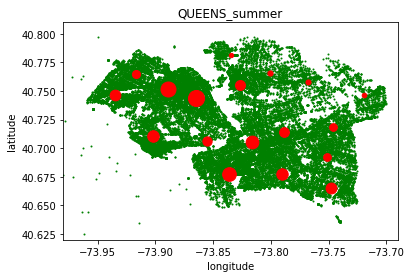

In [12]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/300)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_summer")

### QUEENS_fall

In [13]:
fall = df1.rdd.filter(lambda x: x[3]=='09' or x[3]=='10' or x[3]=='11')
fall = fall.filter(lambda x: x[2]=="QUEENS")
fall = fall.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
fall = fall.map(lambda x: [x[0], x[1]])

loc_fall = fall.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_fall)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.721645|  -73.8026|[40.721645,-73.8026]|
| 40.66901| -73.80265|[40.66901,-73.80265]|
|40.737865|-73.876144|[40.737865,-73.87...|
|40.708923| -73.81877|[40.708923,-73.81...|
|40.748962| -73.89176|[40.748962,-73.89...|
|40.722515| -73.73332|[40.722515,-73.73...|
|40.692127| -73.83484|[40.692127,-73.83...|
|40.753994| -73.94244|[40.753994,-73.94...|
| 40.78322| -73.84586|[40.78322,-73.84586]|
|40.680077|-73.852684|[40.680077,-73.85...|
| 40.72218| -73.84406|[40.72218,-73.84406]|
| 40.72717| -73.78739|[40.72717,-73.78739]|
|40.683323| -73.80648|[40.683323,-73.80...|
|40.697083| -73.85476|[40.697083,-73.85...|
| 40.73844| -73.88628|[40.73844,-73.88628]|
|40.748318| -73.87742|[40.748318,-73.87...|
| 40.74606| -73.85583|[40.74606,-73.85583]|
| 40.68329| -73.85491|[40.68329,-73.85491]|
|  40.6639|  -73.7804|  [40.6639,-73.7804]|
|40.675255| -73.73207|[40.675255

In [14]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.721645|  -73.8026|[40.721645,-73.8026]|        13|
| 40.66901| -73.80265|[40.66901,-73.80265]|         7|
|40.737865|-73.876144|[40.737865,-73.87...|         9|
|40.708923| -73.81877|[40.708923,-73.81...|        13|
|40.748962| -73.89176|[40.748962,-73.89...|         6|
|40.722515| -73.73332|[40.722515,-73.73...|        15|
|40.692127| -73.83484|[40.692127,-73.83...|        12|
|40.753994| -73.94244|[40.753994,-73.94...|         0|
| 40.78322| -73.84586|[40.78322,-73.84586]|        10|
|40.680077|-73.852684|[40.680077,-73.85...|        12|
| 40.72218| -73.84406|[40.72218,-73.84406]|         3|
| 40.72717| -73.78739|[40.72717,-73.78739]|        17|
|40.683323| -73.80648|[40.683323,-73.80...|         7|
|40.697083| -73.85476|[40.697083,-73.85...|        12|
| 40.73844| -73.88628|[40.73844,-73.88628]|         9|
|40.748318

In [15]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.7507069  -73.93291779]
[ 40.6005594  -73.75988456]
[ 40.7392117  -73.71705371]
[ 40.72319773 -73.86034997]
[ 40.70440827 -73.79171334]
[ 40.7109838  -73.90178967]
[ 40.75611021 -73.90144775]
[ 40.68059354 -73.81592308]
[ 40.75944344 -73.74713728]
[ 40.75067663 -73.87209619]
[ 40.78178024 -73.83448542]
[ 40.66990656 -73.74035051]
[ 40.68174562 -73.84663686]
[ 40.71597218 -73.81866187]
[ 40.7690453  -73.79741435]
[ 40.71017594 -73.74876815]
[ 40.67164827 -73.77211929]
[ 40.74563978 -73.77927288]
[ 40.58769064 -73.82228558]
[ 40.75685477 -73.82630568]


Text(0.5,1,'QUEENS_fall')

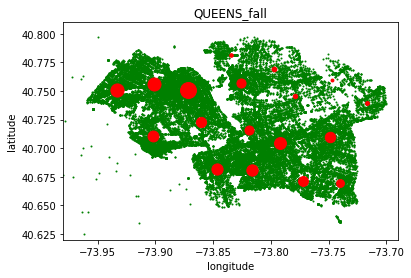

In [16]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/300)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_fall")

### QUEENS_winter

In [17]:
winter = df1.rdd.filter(lambda x: x[3]=='12' or x[3]=='01' or x[3]=='02')
winter = winter.filter(lambda x: x[2]=="QUEENS")
winter = winter.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
winter = winter.map(lambda x: [x[0], x[1]])

loc_winter = winter.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_winter)
new_df.show()

+------------------+----------+--------------------+
|          latitude| longitude|            features|
+------------------+----------+--------------------+
|40.675883999999996| -73.75577|[40.6758839999999...|
|          40.66684| -73.78941|[40.66684,-73.78941]|
|          40.75373| -73.88505|[40.75373,-73.88505]|
|          40.70447| -73.90148|[40.70447,-73.90148]|
|         40.653023| -73.73895|[40.653023,-73.73...|
|         40.593636|-73.797264|[40.593636,-73.79...|
|         40.674263| -73.80453|[40.674263,-73.80...|
|         40.754295| -73.93946|[40.754295,-73.93...|
|         40.752777| -73.70743|[40.752777,-73.70...|
|          40.70546|  -73.7949| [40.70546,-73.7949]|
|          40.76104| -73.88162|[40.76104,-73.88162]|
|          40.75245| -73.94507|[40.75245,-73.94507]|
|         40.752045|-73.879036|[40.752045,-73.87...|
|         40.766827|-73.909294|[40.766827,-73.90...|
|         40.766743| -73.92597|[40.766743,-73.92...|
|          40.73376| -73.93743|[40.73376,-73.9

In [18]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+------------------+----------+--------------------+----------+
|          latitude| longitude|            features|prediction|
+------------------+----------+--------------------+----------+
|40.675883999999996| -73.75577|[40.6758839999999...|         9|
|          40.66684| -73.78941|[40.66684,-73.78941]|        14|
|          40.75373| -73.88505|[40.75373,-73.88505]|        12|
|          40.70447| -73.90148|[40.70447,-73.90148]|        11|
|         40.653023| -73.73895|[40.653023,-73.73...|         9|
|         40.593636|-73.797264|[40.593636,-73.79...|         4|
|         40.674263| -73.80453|[40.674263,-73.80...|        13|
|         40.754295| -73.93946|[40.754295,-73.93...|        18|
|         40.752777| -73.70743|[40.752777,-73.70...|        16|
|          40.70546|  -73.7949| [40.70546,-73.7949]|         7|
|          40.76104| -73.88162|[40.76104,-73.88162]|        12|
|          40.75245| -73.94507|[40.75245,-73.94507]|        18|
|         40.752045|-73.879036|[40.75204

In [19]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.69197102 -73.76945533]
[ 40.7624308  -73.91519362]
[ 40.71264534 -73.74550837]
[ 40.67533393 -73.84579881]
[ 40.5872453  -73.82270292]
[ 40.76579712 -73.8255838 ]
[ 40.73915033 -73.86340821]
[ 40.69957185 -73.80406188]
[ 40.70396686 -73.8497035 ]
[ 40.66950252 -73.74156603]
[ 40.76156057 -73.77725523]
[ 40.71109476 -73.90073313]
[ 40.75219983 -73.88488604]
[ 40.67870181 -73.8181984 ]
[ 40.66755524 -73.77519288]
[ 40.60051952 -73.75984035]
[ 40.7454041  -73.72210946]
[ 40.719542   -73.78496293]
[ 40.74671806 -73.93515887]
[ 40.72556802 -73.81785828]


Text(0.5,1,'QUEENS_winter')

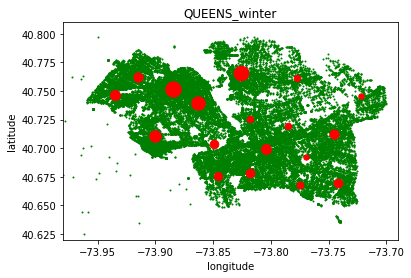

In [20]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            x.append(i[0])
            y.append(i[1])
    

    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74 and i[1]<-73.7:
        if i[0]>40.62 and i[0]<40.80:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/300)
            idx+=1

plt.xlim([-73.98, -73.69])  
plt.ylim([40.62, 40.81])
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("QUEENS_winter")